## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12145786977244897594
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6978882765
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10425189186606658002
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_teacher_forcing
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_teacher_forcing_1-64'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 64 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 3)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_outputs_1)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, ?, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 64), (None,  17664       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, None, 64), ( 17664       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1

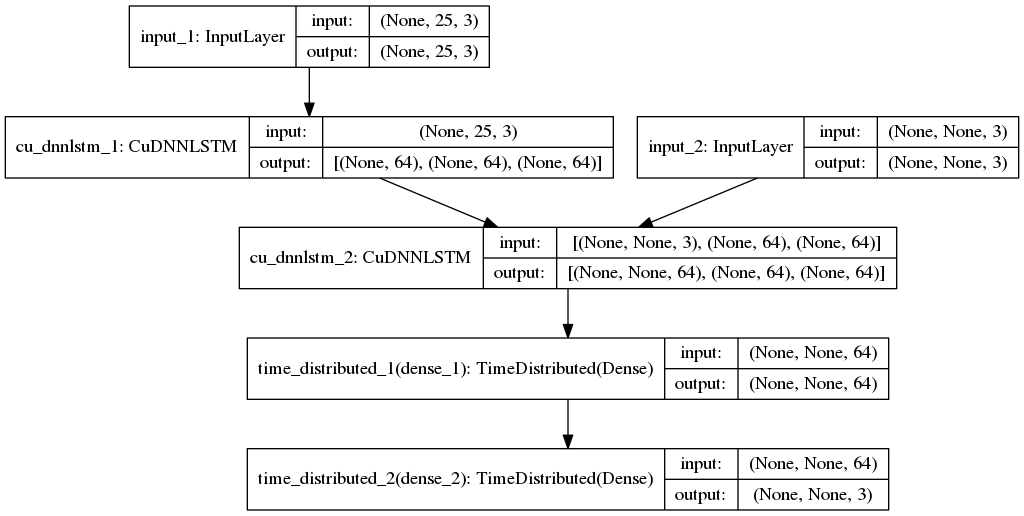

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(inputs=[encoder_inputs], outputs=encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1]

decoder_outputs_1, state_h1, state_c1 = decoder_1(decoder_inputs, initial_state=decoder_states_inputs[0:2])
decoder_states = [state_h1, state_c1]

dense_output_1 = dense_1(decoder_outputs_1)
decoder_outputs = dense_2(dense_output_1)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((len(input_seq), 1, 3))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[:, 0, :] = np.sum(input_seq[:, -n_delay:, :], axis=1)

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((len(input_seq), len_delay, 3))
    
    for i in range(len_delay):
        output, h1, c1 = decoder_model.predict([target_seq] + states_value)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((len(input_seq), 1, 3))
        target_seq[:, 0, :] = output[:,0,:]
        decoded_seq[:,i,:] = output[:,0,:]

        # Update states
        states_value = [h1, c1]

    return decoded_seq

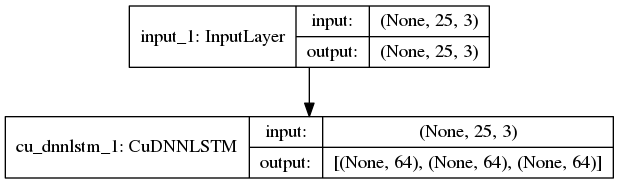

In [7]:
plot_model(encoder_model, to_file=experiment_name+'.png', show_shapes=True)

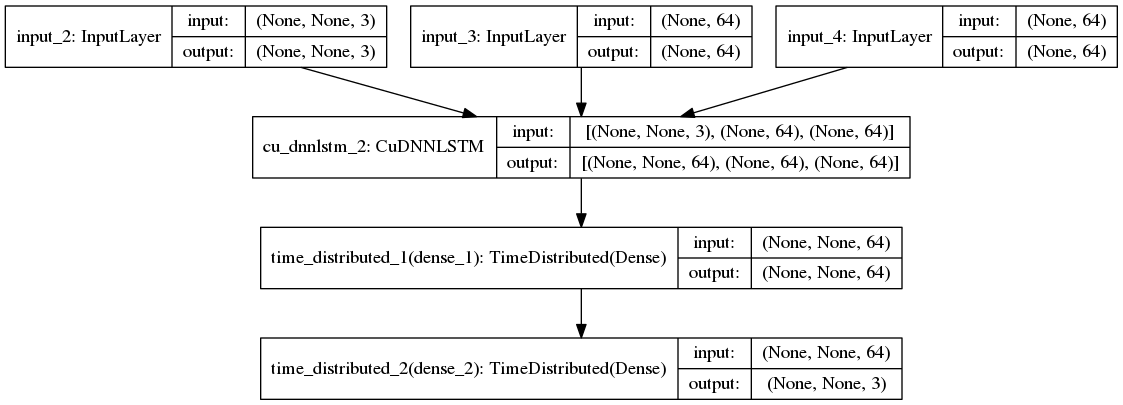

In [8]:
plot_model(decoder_model, to_file=experiment_name+'.png', show_shapes=True)

In [9]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [10]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)

path_to_sensor_data_test = os.path.join(dir_path, "preprocessed_test")
file_names_test = os.listdir(path_to_sensor_data_test)

print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [11]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

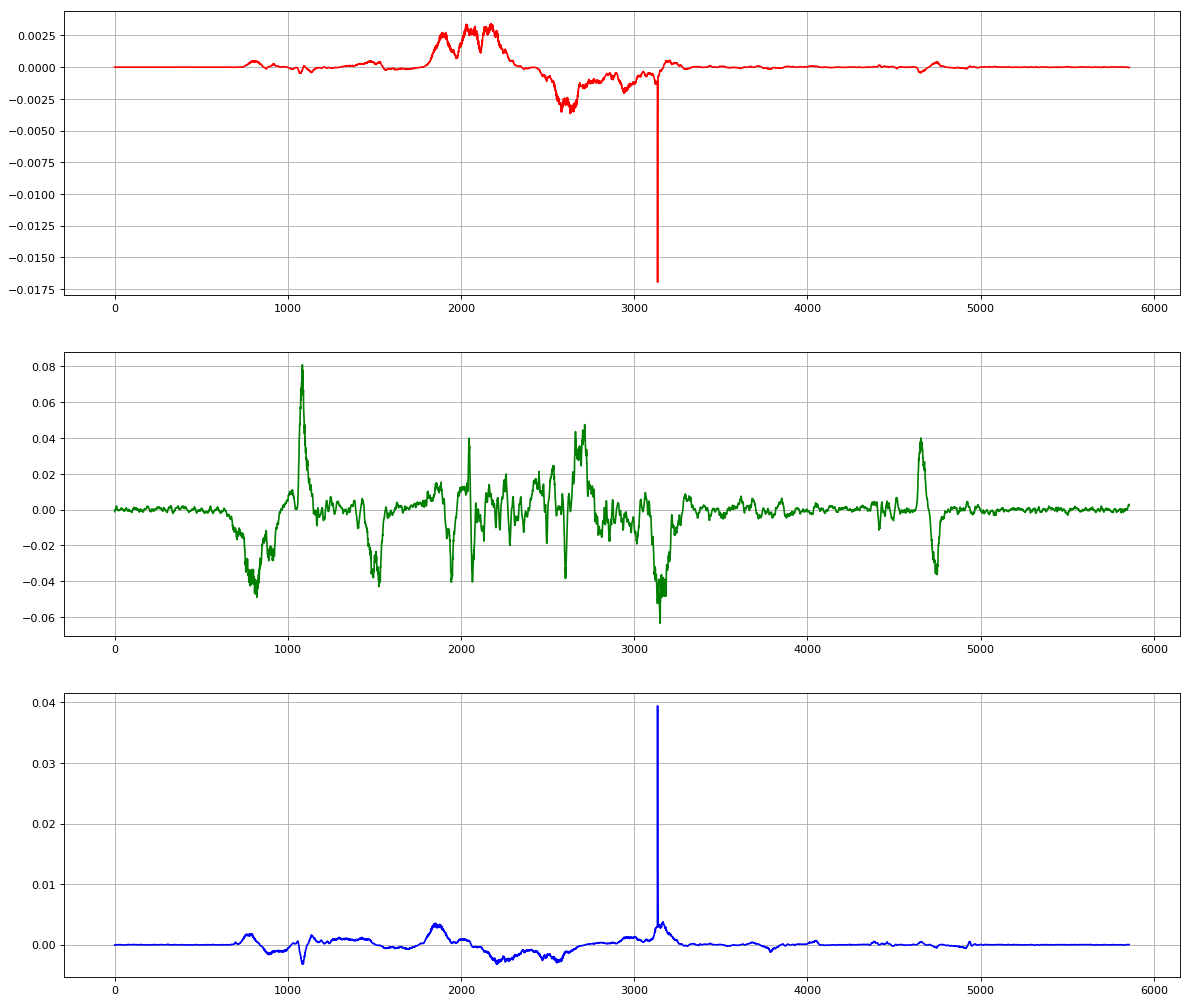

In [12]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [13]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150
542/542 [==============================] - 27s 51ms/step - loss: 0.0357 - rmse: 0.0935 - val_loss: 0.0315 - val_rmse: 0.0852
Epoch 2/150
  3/542 [..............................] - ETA: 13s - loss: 0.0251 - rmse: 0.0616

/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


542/542 [==============================] - 26s 49ms/step - loss: 0.0295 - rmse: 0.0785 - val_loss: 0.0303 - val_rmse: 0.0830
Epoch 3/150
542/542 [==============================] - 27s 50ms/step - loss: 0.0282 - rmse: 0.0766 - val_loss: 0.0290 - val_rmse: 0.0823
Epoch 4/150
542/542 [==============================] - 27s 50ms/step - loss: 0.0278 - rmse: 0.0760 - val_loss: 0.0289 - val_rmse: 0.0811
Epoch 5/150
542/542 [==============================] - 28s 51ms/step - loss: 0.0276 - rmse: 0.0758 - val_loss: 0.0286 - val_rmse: 0.0810
Epoch 6/150
542/542 [==============================] - 28s 51ms/step - loss: 0.0273 - rmse: 0.0753 - val_loss: 0.0285 - val_rmse: 0.0804
Epoch 7/150
542/542 [==============================] - 28s 51ms/step - loss: 0.0272 - rmse: 0.0752 - val_loss: 0.0283 - val_rmse: 0.0805
Epoch 8/150
542/542 [==============================] - 27s 50ms/step - loss: 0.0272 - rmse: 0.0751 - val_loss: 0.0283 - val_rmse: 0.0802
Epoch 9/150
542/542 [==============================] 

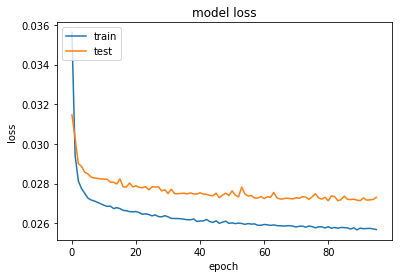

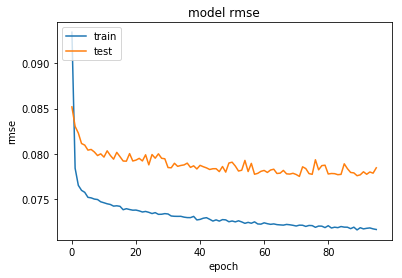

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [16]:
model.load_weights(experiment_name+'.hdf5')

In [17]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

test_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_test,
                                         file_names_test,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay
                                        )

test_gen_pred = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_test,
                                         file_names_test,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_rmse_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_smape_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_mfe_test = np.zeros((len(file_names_test), 1+len_delay))

count = 0

start = time.time()
print("Etestuating testidation data...")

for [encoder_input, decoder_input], Y_test_abs in test_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = decode_sequence(encoder_input)
    
    # From normalized differences to absolute testues
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_test_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_test_abs = Y_test_abs[:, 1:]

    predictions_mae_test[count, 0] = get_mae(Y_pred, Y_test_abs)
    predictions_rmse_test[count, 0] = get_rmse(Y_pred, Y_test_abs)
    predictions_smape_test[count, 0] = get_smape(Y_pred, Y_test_abs)
    predictions_mfe_test[count, 0] = get_mfe(Y_pred, Y_test_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_test = Y_test_abs[: ,ind_delay]
        
        predictions_mae_test[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_test)
        predictions_rmse_test[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_test)
        predictions_smape_test[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_test)
        predictions_mfe_test[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_test)
    
    count += 1
    if count == len(file_names_test):
        break

results_mae_test = np.mean(predictions_mae_test, axis=0)
results_rmse_test = np.mean(predictions_rmse_test, axis=0)
results_smape_test = np.mean(predictions_smape_test, axis=0)
results_mfe_test = np.mean(predictions_mfe_test, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Etestuating testidation data...
Evaluation Time :  156.74697995185852 s =  2.6124496777852375 min =  0.04354082802931468 h


## Evaluate performance on validation data to improve model

## Evaluate metrics

In [18]:
print("MAE")
print("Average mae:", results_mae_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_test[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_test[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_test[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_test[i+1])

MAE
Average mae: 0.057634798800004494
Delay 100 ms: 0.0037266632678569383
Delay 200 ms: 0.01218129040930453
Delay 300 ms: 0.023322029405626412
Delay 400 ms: 0.035829855393860716
Delay 500 ms: 0.04907681450982597
Delay 600 ms: 0.0627238555369037
Delay 700 ms: 0.0765751761744285
Delay 800 ms: 0.09049414705278509
Delay 900 ms: 0.10435741002430589
Delay 1000 ms: 0.11806074622514708

RMSE
Average rmse: 0.1218267846262573
Delay 100 ms: 0.009730886240142586
Delay 200 ms: 0.025481427269702043
Delay 300 ms: 0.04603120259084006
Delay 400 ms: 0.06860688405869218
Delay 500 ms: 0.09179056038903212
Delay 600 ms: 0.11490493699092835
Delay 700 ms: 0.13769273984141897
Delay 800 ms: 0.16001993219571736
Delay 900 ms: 0.18181165943538935
Delay 1000 ms: 0.2029647541172983

SMAPE
Average smape: 14.206982906344846
Delay 100 ms: 2.077204549512718
Delay 200 ms: 5.251479073691887
Delay 300 ms: 8.318043920225337
Delay 400 ms: 11.119083027694938
Delay 500 ms: 13.701212749790818
Delay 600 ms: 16.09965729178953
Del